In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd

from alns import ALNS, State
from alns.criteria import HillClimbing

In [2]:
%matplotlib inline

In [3]:
SEED = 5432

# The cutting-stock problem

The [cutting-stock problem (CSP)](https://en.wikipedia.org/wiki/Cutting_stock_problem) is well-known problem in operations research. Many different formulations exist, e.g. for the one-, two-, and even three-dimensional case. Here we solve an instance of the one-dimensional problem, obtained from the data [here](http://www.math.tu-dresden.de/~capad/cpd-ti.html#1D). It is known that the optimal solution for this problem requires the use of only 74 beams.

In [4]:
OPTIMAL_BEAMS = 74

In [5]:
with open('640.csp') as file:
    data = file.readlines()

NUM_BEAMS = int(data[0])
BEAM_LENGTH = int(data[1])

# Beams to be cut from the available beams
BEAMS = [int(length)
         for datum in data[2:]
         for length, amount in [datum.strip().split()]
         for _ in range(int(amount))]

print("Total number of beams available:", NUM_BEAMS)
print("Each available beam is of length:", BEAM_LENGTH)

print("Number of beams to be cut (orders):", len(BEAMS))

Total number of beams available: 165
Each available beam is of length: 1000
Number of beams to be cut (orders): 180


## Operators and solution state

To use the ALNS meta-heuristic, we need to have destroy and repair operators that work on a proposed solution, and a way to describe such a solution in the first place. The ALNS package exposes the class ``State`` to describe a solution, with an ``objective()`` member that computes this solution's objective value. Using it, we may compute a simple initial solution, and then apply the ALNS algorithm.

## Solution state

In [6]:
class CspState(State):
    """
    Solution state for the CSP problem. It has two members, assignments and 
    unassigned .Assignments is a list of length NUM_BEAMS. Each entry is
    another list, containing the ordered beams cut from this beam. Each such
    sublist must sum to less than or equal to BEAM_LENGTH. Unassigned is a 
    list of ordered beams that are not currently assigned to one of the 
    available beams.
    """
    
    def __init__(self, assignments, unassigned=None):
        self.assignments = assignments
        self.unassigned = []
        
        if unassigned is not None:
            self.unassigned = unassigned

    @property
    def num_beams(self):
        return sum(1
                   for assignment in self.assignments
                   if len(assignment) != 0)

    def copy(self):
        """
        Helper method to ensure each solution state is immutable.
        """
        return CspState(copy.deepcopy(self.assignments),
                        self.unassigned.copy())

    def objective(self):
        """
        Computes the objective values, as the 'wasted' parts of each used 
        beam.
        """
        return sum(BEAM_LENGTH - sum(assignment) 
                   for assignment in self.assignments
                   if len(assignment) != 0)

    def plot(self):
        """
        Helper method to plot a solution.
        """
        lengths = [sum(assignment)
                   for assignment in self.assignments]
        
        fig, ax = plt.subplots(figsize=(12, 6))
      
        ax.barh(np.arange(len(self.assignments)), 
                lengths, 
                height=1)

        ax.set_xlim(right=BEAM_LENGTH)
        ax.set_yticks(np.arange(len(self.assignments), step=10))

        ax.margins(x=0, y=0)

        ax.set_xlabel('Usage')
        ax.set_ylabel('Beam (#)')

        plt.draw_if_interactive()

# Destroy operators

We will consider two simple destroy operators, **random_removal** and **worst_removal**. Random removal randomly removes currently assigned beams, whereas worst removal removes those beams that are currently cut with the most waste. Both remove a fixed percentage of the current solution state, controlled by a degree of destruction parameter.

In [7]:
degree_of_destruction = 0.25

def beams_to_remove():
    return int(NUM_BEAMS * degree_of_destruction)

In [8]:
def random_removal(state, random_state):
    """
    Iteratively removes randomly chosen beam assignments.
    """
    state = state.copy()

    for _ in range(beams_to_remove()):
        idx = random_state.randint(NUM_BEAMS)

        state.unassigned.extend(state.assignments[idx])
        state.assignments[idx] = []

    return state

In [9]:
def worst_removal(state, random_state):
    """
    Removes beams in decreasing order of wastage, such that the
    poorest assignments are removed first.
    """
    state = state.copy()
    
    def value(assignment):    # helper method for sorting
        return BEAM_LENGTH - sum(assignment) if len(assignment) != 0 else 0
    
    # Sort assignments by wastage, worst first
    worst_assignments = sorted(state.assignments, key=value, reverse=True)

    # Removes the worst assignments
    for _ in range(beams_to_remove()):
        state.unassigned.extend(worst_assignments.pop(0))

    # Reset assignments to the remaining list of assigned beams
    state.assignments = [[] for _ in range(NUM_BEAMS)]
    state.assignments[:len(worst_assignments)] = worst_assignments

    return state

# Repair operators

We define two equally simple repair operators, **greedy_insert** and **minimal_wastage**. The first considers each currently unassigned ordered beam, and finds the first beam this order may be inserted into. The second does something similar, but finds a beam where its insertion would result in the smallest beam wastage.

In [10]:
def greedy_insert(state, random_state):
    """
    Inserts the unassigned beams greedily into the first fitting
    beam. Shuffles the unassigned ordered beams before inserting.
    """
    random_state.shuffle(state.unassigned)

    while len(state.unassigned) != 0:
        beam = state.unassigned.pop(0)

        for idx, assignment in enumerate(state.assignments):
            if sum(assignment) + beam <= BEAM_LENGTH:
                state.assignments[idx].append(beam)
                break

    return state

In [11]:
def minimal_wastage(state, random_state):
    """
    For every unassigned ordered beam, the operator determines
    which beam would minimise that beam's waste once the ordered
    beam is inserted.
    """
    def wastage(beam, assignment):  # helper method for min
        potential_usage = sum(assignment) + beam
        
        if potential_usage > BEAM_LENGTH:  # beam cannot be
            return BEAM_LENGTH             # inserted here
        
        return BEAM_LENGTH - potential_usage

    while len(state.unassigned) != 0:
        beam = state.unassigned.pop(0)

        min_idx = min(np.arange(NUM_BEAMS),
                      key=lambda idx: wastage(beam, state.assignments[idx]))

        state.assignments[min_idx].append(beam) 

    return state

# Initial solution

In [12]:
rnd_state = rnd.RandomState(SEED)

state = CspState([[] for _ in range(NUM_BEAMS)], BEAMS.copy())
initial_solution = greedy_insert(state, rnd_state)

print("Initial solution has objective value:", initial_solution.objective())
print("Beams needed for initial solution:", initial_solution.num_beams)

Initial solution has objective value: 7098
Beams needed for initial solution: 81


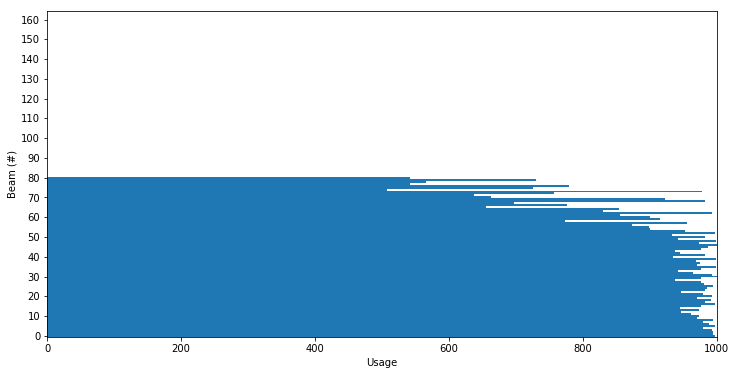

In [13]:
initial_solution.plot()

# Heuristic solution

In [14]:
alns = ALNS(rnd_state)

alns.add_destroy_operator(random_removal)
alns.add_destroy_operator(worst_removal)

alns.add_repair_operator(greedy_insert)
alns.add_repair_operator(minimal_wastage)

In [15]:
criterion = HillClimbing()

result = alns.iterate(initial_solution, [3, 2, 1, 0.5], 0.8, criterion,
                      iterations=5000, collect_stats=True)

solution = result.best_state

objective = solution.objective()

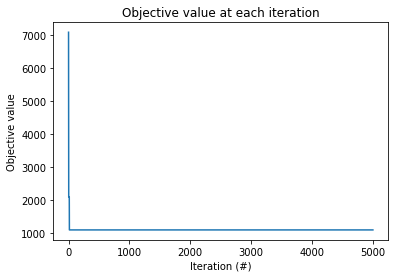

In [16]:
result.plot_objectives()

In [17]:
print("Heuristic solution has objective value:", solution.objective())
print("Beams needed for heuristic solution:", solution.num_beams)

Heuristic solution has objective value: 1098
Beams needed for heuristic solution: 75


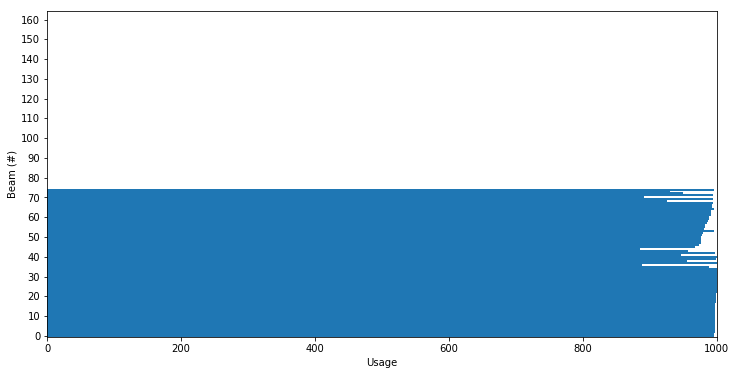

In [18]:
solution.plot()

In [19]:
print("Number of beams used is {0}, which is {1} more than the optimal value, which was {2}."
      .format(solution.num_beams, solution.num_beams - OPTIMAL_BEAMS, OPTIMAL_BEAMS))

Number of beams used is 75, which is 1 more than the optimal value, which was 74.


# Conclusions

In the code above we implement a simple ALNS-based heuristic for the CSP. Although the operators are simple and few, we do find very good results in limited time: we require just one more beam than optimal solution does, a result that is **1.35%** above optimal.

This notebook offers another case where the ALNS library may be put to use to construct powerful, efficient heuristic pipelines from simple, locally greedy operators.